# Improving Graph

We will improve our graph by:
1. Defining clear edge weights (and later node size)
2. Using better visualizations using Plotly which is interactive

In [1]:
import networkx as nx
import json

import math
import statistics
from sklearn import preprocessing # to normalize

from collections import Counter, defaultdict, OrderedDict

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import numpy as np

## Reading Data

In [3]:
# ns_subreddit
with open("ns_subreddit_2021-01.json") as infile1:
    ns_subreddit_01 = json.load(infile1)
    
with open("ns_subreddit_2021-02.json") as infile2:
    ns_subreddit_02 = json.load(infile2)
    
with open("ns_subreddit_2021-03.json") as infile3:
    ns_subreddit_03 = json.load(infile3)
    
with open("ns_subreddit_2021-04.json") as infile4:
    ns_subreddit_04 = json.load(infile4)
    
with open("ns_subreddit_2021-05.json") as infile5:
    ns_subreddit_05 = json.load(infile5)
    
with open("ns_subreddit_2021-06.json") as infile6:
    ns_subreddit_06 = json.load(infile6)
   
# subreddit_ns
with open("subreddit_ns_2021-01.json") as infile1a:
    subreddit_ns_01 = json.load(infile1a)
    
with open("subreddit_ns_2021-02.json") as infile2a:
    subreddit_ns_02 = json.load(infile2a)
    
with open("subreddit_ns_2021-03.json") as infile3a:
    subreddit_ns_03 = json.load(infile3a)
    
with open("subreddit_ns_2021-04.json") as infile4a:
    subreddit_ns_04 = json.load(infile4a)
    
with open("subreddit_ns_2021-05.json") as infile5a:
    subreddit_ns_05 = json.load(infile5a)
    
with open("subreddit_ns_2021-06.json") as infile6a:
    subreddit_ns_06 = json.load(infile6a)

Let's define our `news_sources` and `subreddits`.

In [4]:
news_sources = list(set(ns_subreddit_01.keys()) & 
                    set(ns_subreddit_02.keys()) & 
                    set(ns_subreddit_03.keys()) & 
                    set(ns_subreddit_04.keys()) & 
                    set(ns_subreddit_05.keys()) & 
                    set(ns_subreddit_06.keys()))
len(news_sources)

2687

In [5]:
subreddits = list(set(subreddit_ns_01.keys()) &
                  set(subreddit_ns_02.keys()) &
                 set(subreddit_ns_03.keys()) &
                 set(subreddit_ns_04.keys()) &
                 set(subreddit_ns_05.keys()) &
                 set(subreddit_ns_06.keys()))
len(subreddits)

5699

Let's only use subreddits with the most subscribers

In [6]:
# Let's only use the subreddits that have lots of subscribers
with open ("subreddit_subscribers.json", "r", encoding = "utf-8") as infile:
    subreddit_subscribers = json.load(infile)

In [7]:
subreddits_w_subc = [subreddits[k] for k in range(len(subreddits)) if subreddits[k] in subreddit_subscribers]
len(subreddits_w_subc)

5238

Out of our 5.7k subreddits, we only have subscribers data for 5.2k of them. Let's drop the descriptions with `None` values.

In [8]:
subreddits_w_subc = [s for s in subreddits_w_subc if subreddit_subscribers[s] is not None]
len(subreddits_w_subc)

5236

In [9]:
srs_all = sorted(subreddits_w_subc, key= lambda x: subreddit_subscribers[x], reverse= True)

In [10]:
# example number of subsribers
[(s,subreddit_subscribers[s]) for s in srs_all[:10] if subreddit_subscribers[s] > 0]

[('funny', 31060166),
 ('gaming', 26628444),
 ('aww', 25197817),
 ('pics', 24911449),
 ('science', 24268001),
 ('worldnews', 24253881),
 ('Music', 24041486),
 ('videos', 23114010),
 ('movies', 23087255),
 ('todayilearned', 23030716)]

Text(0.5, 1.0, 'All Subreddit Subscribers')

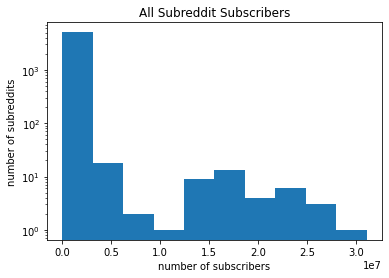

In [11]:
# plt.hist([subreddit_subscribers[s] for s in srs_all if subreddit_subscribers[s] > 0])

plt.yscale("log")
plt.hist([subreddit_subscribers[s] for s in srs_all if subreddit_subscribers[s] > 0])
plt.xlabel("number of subscribers")
plt.ylabel("number of subreddits")
plt.title("All Subreddit Subscribers")

# could log scale for both x and y

In [12]:
len([subreddit_subscribers[s] for s in srs_all if subreddit_subscribers[s] > 0])

5118

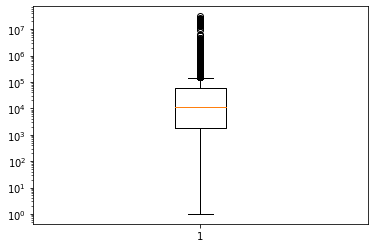

In [13]:
plt.boxplot([subreddit_subscribers[s] for s in srs_all if subreddit_subscribers[s] > 0])
plt.yscale("log")

Text(0.5, 1.0, 'Top 1k Subreddit Subscribers')

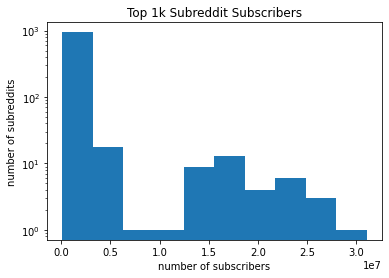

In [14]:
# plt.hist([subreddit_subscribers[s] for s in srs_all if subreddit_subscribers[s] > 0])

plt.close()
plt.yscale("log")
plt.hist([subreddit_subscribers[s] for s in srs_all[:1000] if subreddit_subscribers[s] > 0])
plt.xlabel("number of subscribers")
plt.ylabel("number of subreddits")
plt.title("Top 1k Subreddit Subscribers")

# could log scale for both x and y

In [15]:
# srs_1000 = srs_all[:1000]
srs_1000 = srs_all[:500] # using 1000 subreddits yields in very condensed graph.

## Edges and Nodes

As edge weight, we use the formula

(min/max) * ((min+max)/2)

In [16]:
subreddit_files = [subreddit_ns_01, subreddit_ns_02, subreddit_ns_03, subreddit_ns_04, subreddit_ns_05, subreddit_ns_06]

First we calculate the strength of relationship between two nodes, based on each of the number of their occurences in each subreddit they co-occur in.

In [17]:
# co_occurences = defaultdict(int)
per_subreddits = defaultdict(list)
node_sizes = defaultdict(int)

for subreddit_file in subreddit_files:
    for s in subreddit_file:
        # we will only process for this subreddit if it is one of the 1k subreddits with the most subscribers
        if s not in srs_1000:
            continue
        # each s contains news sources and how many times they appear
        news_sources1 = list(subreddit_file[s].keys())
        # make pairings
        i = 0
        while i < len(news_sources1)-1:
            # record node details for this particular news source
            node_sizes[news_sources1[i]] += 1
            j = i + 1
            while j <= len(news_sources1)-1:
                ns_pair = sorted([news_sources1[i], news_sources1[j]])
                # cast to be tuple after sorting in alphabetical pair
                ns_pair = tuple(ns_pair)
                n1, n2 = ns_pair
                # the pairing co_occur in this subreddit
                # co_occurences[ns_pair] += 1 # old
                # let's find the min and max subscribers
                s1 = subreddit_file[s][n1]
                s2 = subreddit_file[s][n2]
                maxx = max(s1,s2)
                minn = min(s1,s2)
                # then calculate the weight for this one 
                weight = (minn/maxx)*((minn+maxx)/2)
                per_subreddits[ns_pair].append(weight)
                j += 1
            i += 1
        # increment for the last news source
        node_sizes[news_sources1[-1]] += 1

In [18]:
per_subreddits[('imdb.com', 'nytimes.com')]

[0.50187265917603,
 9.041666666666668,
 0.6000000000000001,
 0.5208333333333333,
 1.3333333333333333,
 0.5069444444444444,
 23.211267605633804,
 3.333333333333333,
 9.272727272727272,
 1.4000000000000001,
 4.955056179775281,
 0.6000000000000001,
 1.0206185567010309,
 0.625,
 0.6666666666666666,
 1.0,
 0.75,
 2.4,
 0.75,
 0.6666666666666666,
 0.525,
 1.0,
 1.0,
 0.5833333333333333,
 2.25,
 1.0,
 0.75,
 1.0,
 1.0,
 0.75,
 0.75,
 0.625,
 1.0,
 0.75,
 3.5806451612903225,
 1.0040080160320641,
 0.55,
 1.025974025974026,
 27.876712328767123,
 3.888888888888889,
 2.4,
 16.043478260869566,
 11.176470588235293,
 0.5333333333333333,
 0.6666666666666666,
 1.1333333333333333,
 1.0,
 2.0,
 1.0333333333333332,
 0.55,
 2.4,
 0.6000000000000001,
 0.5625,
 0.75,
 1.037037037037037,
 0.75,
 1.0,
 0.55,
 1.0,
 2.0,
 0.5384615384615385,
 15.11111111111111,
 1.6666666666666665,
 0.5108695652173912,
 2.530940594059406,
 37.66025641025641,
 2.2758620689655173,
 0.53125,
 0.75,
 0.5625,
 0.5121951219512195,
 1

Let's only consider pairings that co-occur at least 10 times.

In [28]:
per_subreddits_10 = {p: per_subreddits[p] for p in per_subreddits if len(per_subreddits[p]) >= 10}

In [30]:
len(per_subreddits)

1716593

In [31]:
len(per_subreddits_10)

209029

Then, we take an average of the strengths and set the edge weight to be this. I could also use the maximum value. Should I?

In [32]:
weights = defaultdict(int)

for pair in per_subreddits_10:
    weights[pair] = statistics.mean(per_subreddits[pair])

In [21]:
weights[('imdb.com', 'nytimes.com')]

2.9240840582272316

In [22]:
len(weights)

209029

Now (I think) we are ready to build our graph!

## Preparing for Building a Graph

In [23]:
G = nx.Graph()
for e, w in list(weights.items()):
    u, v = e
    G.add_edge(u, v, weight=w)

In [24]:
# sanity check
'nytimes.com' in G.nodes()

True

In [25]:
len(G.nodes())

1355

In [26]:
len(G.edges())

209029

Let's first visualize the node sizes and edge weights.

Text(0.5, 1.0, 'Node Sizes')

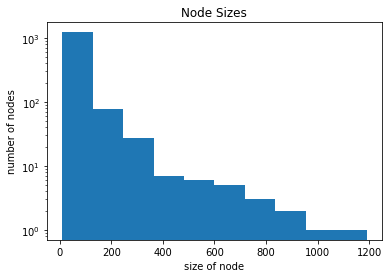

In [27]:
# Node Size
plt.close()
plt.hist([node_sizes[n] for n in G.nodes()])
plt.yscale("log")
plt.ylabel("number of nodes")
plt.xlabel("size of node")
plt.title("Node Sizes")

Text(0.5, 1.0, 'Edge Weights')

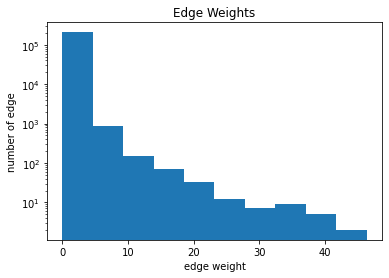

In [33]:
# Edge Weight
plt.close()
plt.hist([weights[n] for n in G.edges()])
plt.yscale("log")
plt.ylabel("number of edge")
plt.xlabel("edge weight")
plt.title("Edge Weights")

In [34]:
len(G.edges())

209029

# *Questionable decision here*

In [36]:
# let's take out edges that are of weight <5
weights_filtered = {e:weights[e] for e in weights if weights[e] >= 5}

In [37]:
len(weights_filtered)

1911

Text(0.5, 1.0, 'Edge Weights (Filtered)')

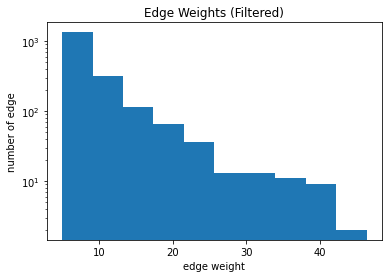

In [39]:
# Edge Weight
plt.close()
plt.hist([weights_filtered[n] for n in weights_filtered])
plt.yscale("log")
plt.ylabel("number of edge")
plt.xlabel("edge weight")
plt.title("Edge Weights (Filtered)")

The majority of edges have weights between 0 and 10. About 100 edges have weight between 10 and 25.

Then, make new graph.

In [47]:
G = nx.Graph()
for e, w in list(weights_filtered.items()):
    u, v = e
    G.add_edge(u, v, weight=w)

In [48]:
# check
'nytimes.com' in G.nodes()

True

In [49]:
len(G.edges)

1911

In [50]:
len(G.nodes)

273

In [51]:
# explicit function to normalize array
def normalize(arr):
    arr = np.array([arr])
    norm = np.linalg.norm(arr)
    arr = arr/norm  # normalized matrix
    return arr

Let's freeze the ordering of the edges and their weights

In [52]:
freeze_edges = list(weights_filtered.keys())

In [69]:
len(freeze_edges) == len(G.edges())

True

In [70]:
freeze_weights = [weights_filtered[e] for e in freeze_edges]

In [71]:
normalize([1,2,3,4,5,6,7,8,9,10])

array([[0.05096472, 0.10192944, 0.15289416, 0.20385888, 0.2548236 ,
        0.30578831, 0.35675303, 0.40771775, 0.45868247, 0.50964719]])

In [72]:
preprocessing.normalize(preprocessing.normalize(np.array([[1,2,3]])))

array([[0.26726124, 0.53452248, 0.80178373]])

In [73]:
norm_weights = normalize(freeze_weights)[0].tolist()

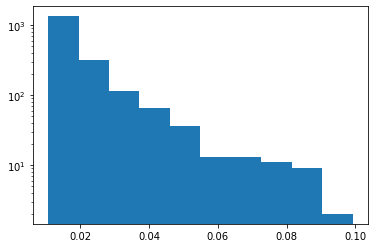

In [74]:
plt.hist(norm_weights)
plt.yscale("log")

In [75]:
min(norm_weights)

0.010713590606177563

In [76]:
max(norm_weights)

0.09914664070808821

Let's multiply the weights by 28.5 so we get maximum weights of 6

In [77]:
norm_weights = [w*30 for w in norm_weights]

In [78]:
max(norm_weights)

2.9743992212426464

(array([1333.,  314.,  114.,   66.,   36.,   13.,   13.,   11.,    9.,
           2.]),
 array([0.32140772, 0.58670687, 0.85200602, 1.11730517, 1.38260432,
        1.64790347, 1.91320262, 2.17850177, 2.44380092, 2.70910007,
        2.97439922]),
 <BarContainer object of 10 artists>)

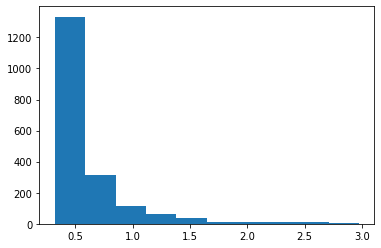

In [79]:
plt.hist(norm_weights)

In [80]:
type(G.edges)

networkx.classes.reportviews.EdgeView

In [81]:
norm_edge_weights = {freeze_edges[i]:norm_weights[i] for i in range(len(norm_weights))}

In [82]:
ordered_weights = [norm_edge_weights[e] for e in G.edges]

KeyError: ('cbssports.com', 'bleacherreport.com')

(array([3.1001e+04, 2.8260e+03, 3.3400e+02, 7.0000e+01, 3.7000e+01,
        2.0000e+01, 1.7000e+01, 6.0000e+00, 4.0000e+00, 1.0000e+00]),
 array([0.        , 0.1654222 , 0.3308444 , 0.4962666 , 0.66168879,
        0.82711099, 0.99253319, 1.15795539, 1.32337759, 1.48879979,
        1.65422199]),
 <BarContainer object of 10 artists>)

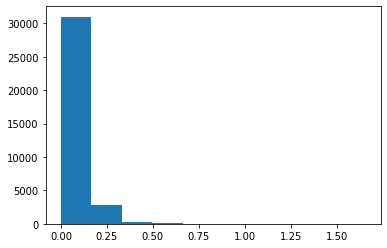

In [44]:
plt.hist(ordered_weights)

# Building a Graph

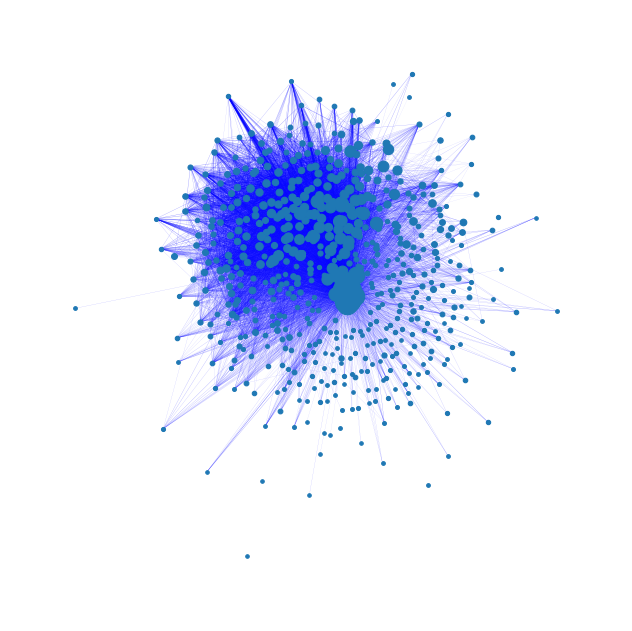

In [227]:
figure(figsize=(8, 8), dpi=80)
pos = nx.kamada_kawai_layout(G) #, seed=7)  # positions for all nodes - seed for reproducibility

# nodes
for nn in G.nodes():
    # print("nn:", nn)
    nx.draw_networkx_nodes(G, pos, nodelist = [nn],
                           node_size=node_sizes[nn])

# edges
# ecount = 0
# for u,v,w in G.edges(data=True):
#     if ecount%100 == 0:
#         print("{}% done".format(ecount*100/len_edges))
nx.draw_networkx_edges(G, pos, 
                       edgelist=G.edges,
                       width = ordered_weights,
                       alpha=0.4, edge_color="b")
#     ecount += 1

# # labels
# nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

# Let's color based on clusters

In [242]:
with open('clusters.json', 'r') as cluster_infile:
    clusters = json.load(cluster_infile)

In [250]:
for i in range(10):
    print(f"Cluster {i} is of length {len(clusters[str(i)])}")

Cluster 0 is of length 2830
Cluster 1 is of length 93
Cluster 2 is of length 447
Cluster 3 is of length 58
Cluster 4 is of length 205
Cluster 5 is of length 246
Cluster 6 is of length 104
Cluster 7 is of length 124
Cluster 8 is of length 442
Cluster 9 is of length 89


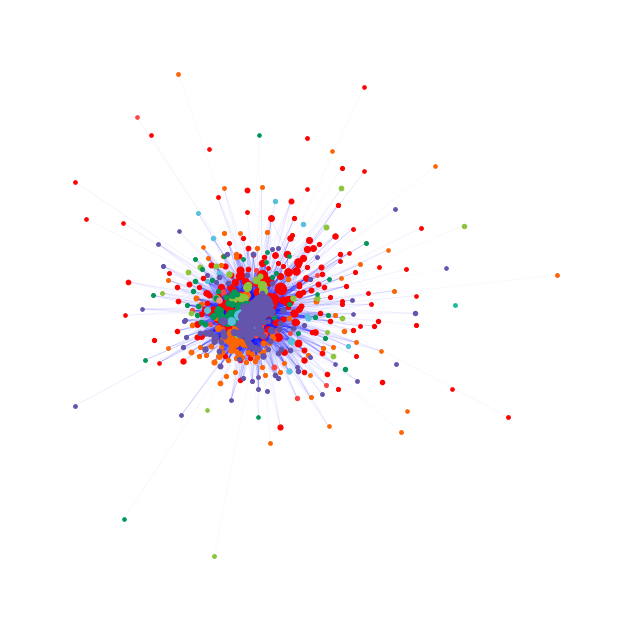

In [254]:
figure(figsize=(8, 8), dpi=80)
pos = nx.spring_layout(G) #, seed=7)  # positions for all nodes - seed for reproducibility

colors = ["#ff0000", "#fc4444", "#fc6404", "#fcd444", "#8cc43c",
         "#029658", "#1abc9c", "#5bc0de", "#6454ac", "#fc8c84"]

# nodes
for i in range(10):
    for nn in clusters[str(i)]:
        if nn in G.nodes():
            nx.draw_networkx_nodes(G, pos, nodelist = [nn],
                               node_size=node_sizes[nn],
                              node_color = colors[i])

# edges
# ecount = 0
# for u,v,w in G.edges(data=True):
#     if ecount%100 == 0:
#         print("{}% done".format(ecount*100/len_edges))
nx.draw_networkx_edges(G, pos, 
                       edgelist=G.edges,
                       width = ordered_weights,
                       alpha=0.4, edge_color="b")
#     ecount += 1

# # labels
# nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

# Trying `plotly`

In [229]:
!pip install plotly

In [230]:
import plotly.graph_objects as go

In [231]:
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

KeyError: 'pos'